Reconocer flores por medio del aprendizaje por transferencia

In [ ]:
import tensorflow as tf
assert tf.__version__.startswith('2')

import os
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
tf.__version__

'2.3.0'

**Configurar canalizacion de entrada**

Primero descargaremos el conjunto de datos de flores

In [ ]:
_URL = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"

zip_file = tf.keras.utils.get_file(origin=_URL, 
                                   fname="flower_photos.tgz", 
                                   extract=True)

base_dir = os.path.join(os.path.dirname(zip_file), 'flower_photos')

228818944/228813984 [==============================] - 3s 0us/step


Usaremos ImageDataGenerator para cambiar la escala de las imágenes.

Cree el generador de trenes y especifique dónde está el directorio del conjunto de datos del tren, el tamaño de la imagen y el tamaño del lote.

Cree el generador de validación con un enfoque similar al del generador de trenes con el método flow_from_directory ().

In [ ]:

IMAGE_SIZE = 224
BATCH_SIZE = 64

datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255, 
    validation_split=0.2)

train_generator = datagen.flow_from_directory(
    base_dir,
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE, 
    subset='training')

val_generator = datagen.flow_from_directory(
    base_dir,
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE, 
    subset='validation')


Found 2939 images belonging to 5 classes.
Found 731 images belonging to 5 classes.


In [ ]:
for image_batch, label_batch in train_generator:
  break
image_batch.shape, label_batch.shape

((64, 224, 224, 3), (64, 5))

Guarde las etiquetas en un archivo que se descargará más tarde.

In [ ]:
print (train_generator.class_indices)

labels = '\n'.join(sorted(train_generator.class_indices.keys()))

with open('labels.txt', 'w') as f:
  f.write(labels)

{'daisy': 0, 'dandelion': 1, 'roses': 2, 'sunflowers': 3, 'tulips': 4}


In [ ]:
!cat labels.txt

daisy
dandelion
roses
sunflowers
tulips

**Crea el modelo base a partir de convnets previamente entrenados**

Cree el modelo base a partir del modelo MobileNet V2 desarrollado en Google y entrenado previamente en el conjunto de datos ImageNet, un gran conjunto de datos de 1,4 millones de imágenes y 1000 clases de imágenes web.

Primero, elija qué capa intermedia de MobileNet V2 se utilizará para la extracción de características. Una práctica común es utilizar la salida de la última capa antes de la operación de aplanar, la llamada "capa de cuello de botella". El razonamiento aquí es que las siguientes capas completamente conectadas estarán demasiado especializadas para la tarea en la que se entrenó la red y, por lo tanto, las características aprendidas por estas capas no serán muy útiles para una nueva tarea. Sin embargo, las características de los cuellos de botella conservan mucha generalidad.

Creemos una instancia de un modelo MobileNet V2 precargado con pesos entrenados en ImageNet. Al especificar el include_top=Falseargumento, cargamos una red que no incluye las capas de clasificación en la parte superior, lo que es ideal para la extracción de características.

In [ ]:
IMG_SHAPE = (IMAGE_SIZE, IMAGE_SIZE, 3)

# Create the base model from the pre-trained model MobileNet V2
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                              include_top=False, 
                                              weights='imagenet')

**Extraccion de Caractericas**

Congelará la base convolucional creada en el paso anterior y la usará como un extractor de características, agregará un clasificador encima y entrenará el clasificador de nivel superior.



In [ ]:
base_model.trainable = False

Agregar un encabezado de clasificiacion

In [ ]:
model = tf.keras.Sequential([
  base_model,
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.GlobalAveragePooling2D(),
  tf.keras.layers.Dense(5, activation='softmax')
])

**Compilar el modelo**

Debe compilar el modelo antes de entrenarlo. Dado que hay varias clases, utilice una pérdida de entropía cruzada categórica.

In [ ]:
model.compile(optimizer=tf.keras.optimizers.Adam(), 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Functi (None, 7, 7, 1280)        2257984   
_________________________________________________________________
conv2d (Conv2D)              (None, 5, 5, 32)          368672    
_________________________________________________________________
dropout (Dropout)            (None, 5, 5, 32)          0         
_________________________________________________________________
global_average_pooling2d (Gl (None, 32)                0         
_________________________________________________________________
dense (Dense)                (None, 5)                 165       
Total params: 2,626,821
Trainable params: 368,837
Non-trainable params: 2,257,984
_________________________________________________________________


In [ ]:
print('Number of trainable variables = {}'.format(len(model.trainable_variables)))

Number of trainable variables = 4


**Entrenar el modelo**

In [ ]:
epochs = 10

history = model.fit(train_generator, 
                    steps_per_epoch=len(train_generator), 
                    epochs=epochs, 
                    validation_data=val_generator, 
                    validation_steps=len(val_generator))

Epoch 1/10
46/46 [==============================] - 128s 3s/step - loss: 0.7901 - accuracy: 0.7513 - val_loss: 0.3839 - val_accuracy: 0.8591
Epoch 2/10
46/46 [==============================] - 127s 3s/step - loss: 0.2715 - accuracy: 0.9075 - val_loss: 0.3715 - val_accuracy: 0.8577
Epoch 3/10
46/46 [==============================] - 127s 3s/step - loss: 0.1699 - accuracy: 0.9476 - val_loss: 0.3923 - val_accuracy: 0.8618
Epoch 4/10
46/46 [==============================] - 126s 3s/step - loss: 0.1182 - accuracy: 0.9650 - val_loss: 0.4074 - val_accuracy: 0.8577
Epoch 5/10
46/46 [==============================] - 130s 3s/step - loss: 0.0756 - accuracy: 0.9775 - val_loss: 0.4325 - val_accuracy: 0.8591
Epoch 6/10
46/46 [==============================] - 126s 3s/step - loss: 0.0458 - accuracy: 0.9905 - val_loss: 0.4498 - val_accuracy: 0.8673
Epoch 7/10
46/46 [==============================] - 128s 3s/step - loss: 0.0295 - accuracy: 0.9952 - val_loss: 0.4482 - val_accuracy: 0.8659
Epoch 8/10
46

**Curvas de Aprendizaje**

Echemos un vistazo a las curvas de aprendizaje de la precisión / pérdida de entrenamiento y validación cuando se utiliza el modelo base de MobileNet V2 como extractor de funciones fijas.

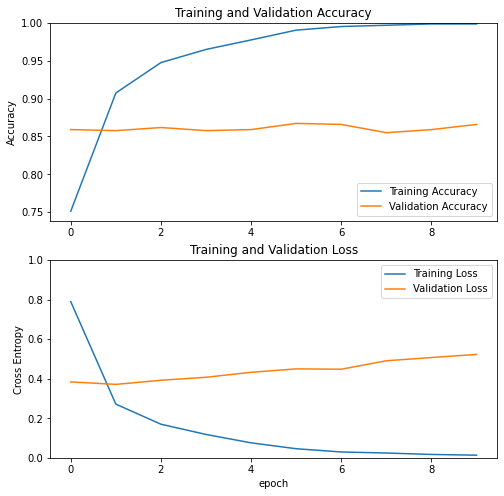

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

**Sintonia FINA**

En nuestro experimento de extracción de funciones, solo estaba entrenando algunas capas sobre un modelo base de MobileNet V2. Los pesos de la red preentrenada no se actualizaron durante el entrenamiento.

Una forma de aumentar aún más el rendimiento es entrenar (o "ajustar") los pesos de las capas superiores del modelo previamente entrenado junto con el entrenamiento del clasificador que agregó. El proceso de entrenamiento obligará a ajustar los pesos de los mapas de características genéricas a las características asociadas específicamente a nuestro conjunto de datos.

**DEsconegele las capas superiores del modelo**

Todo lo que necesita hacer es descongelar base_modely configurar las capas inferiores para que no se puedan entrenar. Luego, vuelva a compilar el modelo (necesario para que estos cambios surtan efecto) y reanude el entrenamiento.

In [ ]:
base_model.trainable = True

In [ ]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable =  False

Number of layers in the base model:  155


**Compilar el modelo**

Compile el modelo usando una tasa de entrenamiento mucho menor.

In [ ]:

model.compile(loss='categorical_crossentropy',
              optimizer = tf.keras.optimizers.Adam(1e-5),
              metrics=['accuracy'])



In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Functi (None, 7, 7, 1280)        2257984   
_________________________________________________________________
conv2d (Conv2D)              (None, 5, 5, 32)          368672    
_________________________________________________________________
dropout (Dropout)            (None, 5, 5, 32)          0         
_________________________________________________________________
global_average_pooling2d (Gl (None, 32)                0         
_________________________________________________________________
dense (Dense)                (None, 5)                 165       
Total params: 2,626,821
Trainable params: 2,231,429
Non-trainable params: 395,392
_________________________________________________________________


In [ ]:
print('Number of trainable variables = {}'.format(len(model.trainable_variables)))

Number of trainable variables = 60


**Continuar el entreno**

In [ ]:
history_fine = model.fit(train_generator, 
                         steps_per_epoch=len(train_generator), 
                         epochs=5, 
                         validation_data=val_generator, 
                         validation_steps=len(val_generator))

Epoch 1/5
46/46 [==============================] - 223s 5s/step - loss: 0.4127 - accuracy: 0.8622 - val_loss: 0.5359 - val_accuracy: 0.8577
Epoch 2/5
46/46 [==============================] - 220s 5s/step - loss: 0.2069 - accuracy: 0.9292 - val_loss: 0.5586 - val_accuracy: 0.8646
Epoch 3/5
46/46 [==============================] - 222s 5s/step - loss: 0.1418 - accuracy: 0.9507 - val_loss: 0.5616 - val_accuracy: 0.8673
Epoch 4/5
46/46 [==============================] - 219s 5s/step - loss: 0.1069 - accuracy: 0.9646 - val_loss: 0.5574 - val_accuracy: 0.8673
Epoch 5/5
46/46 [==============================] - 222s 5s/step - loss: 0.0754 - accuracy: 0.9772 - val_loss: 0.5470 - val_accuracy: 0.8687


**Convierta a TFLite**



Guarde el modelo usando tf.saved_model.savey luego convierta el modelo guardado a un formato compatible con tf lite.

In [ ]:
saved_model_dir = 'save/fine_tuning'
tf.saved_model.save(model, saved_model_dir)

converter = tf.lite.TFLiteConverter.from_saved_model(saved_model_dir)
tflite_model = converter.convert()

with open('model.tflite', 'wb') as f:
  f.write(tflite_model)

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: save/fine_tuning/assets


Descarga el modelo y las etiquetas convertidos

In [ ]:
from google.colab import files

files.download('model.tflite')
files.download('labels.txt')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Echemos un vistazo a las curvas de aprendizaje de la precisión / pérdida de entrenamiento y validación, al ajustar las últimas capas del modelo base de MobileNet V2 y capacitar al clasificador sobre él. La pérdida de validación es mucho mayor que la pérdida de entrenamiento, por lo que puede sufrir un sobreajuste.

También puede obtener un ajuste excesivo, ya que el nuevo conjunto de entrenamiento es relativamente pequeño y similar a los conjuntos de datos originales de MobileNet V2.

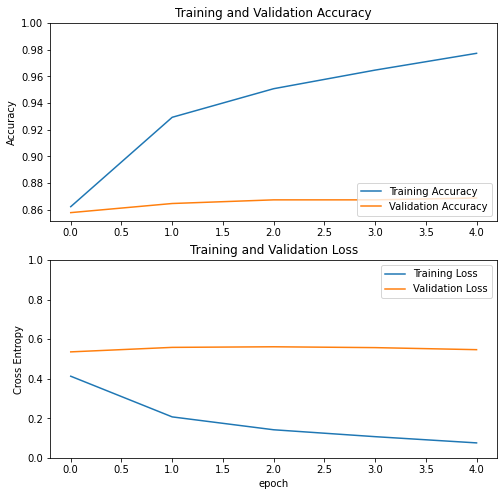

In [ ]:
acc = history_fine.history['accuracy']
val_acc = history_fine.history['val_accuracy']

loss = history_fine.history['loss']
val_loss = history_fine.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

**Resumen**



*   Uso de un modelo previamente entrenado para la extracción de características : cuando se trabaja con un conjunto de datos pequeño, es común aprovechar las características aprendidas por un modelo entrenado en un conjunto de datos más grande en el mismo dominio. Esto se hace creando una instancia del modelo previamente entrenado y agregando un clasificador completamente conectado en la parte superior. El modelo preentrenado se "congela" y solo los pesos del clasificador se actualizan durante el entrenamiento. En este caso, la base convolucional extrajo todas las características asociadas con cada imagen y usted solo entrenó un clasificador que determina la clase de imagen dado ese conjunto de características extraídas.
*   Ajuste de un modelo previamente entrenado : para mejorar aún más el rendimiento, es posible que desee reutilizar las capas de nivel superior de los modelos previamente entrenados para el nuevo conjunto de datos mediante un ajuste fino. En este caso, ajustó sus pesos de manera que su modelo aprendiera características de alto nivel específicas del conjunto de datos. Esta técnica generalmente se recomienda cuando el conjunto de datos de entrenamiento es grande y muy similar al conjunto de datos original en el que se entrenó el modelo previamente entrenado.